In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import random
import pickle
import time

from rdkit import Chem
from rdkit.Chem import Draw


fp_radius = 2
fp_bits = 2048

import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

2023-07-05 14:30:23.757525: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-05 14:30:23.918054: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
from Transformer.Transformer import Transformer, create_look_ahead_mask, create_padding_mask, create_masks, CustomSchedule, evaluate, loss_function, BeamSearch 
from ChemUtils.PreProcessing import read_file, smiles_to_fp_array, CHAR_LEN, array_to_smiles

# Define transformer model and Load weights

In [3]:
smiles_array, fp_array = read_file("Data/train.csv")

num_layers = 4
d_model = 256
num_heads = 8
dff = 2048
input_vocab_size=fp_bits+3
target_vocab_size = CHAR_LEN+3
pe_input = fp_array.shape[1]
pe_target= smiles_array.shape[1]
rate = 0.1
EPOCHS=35

transformer = Transformer(num_layers, d_model, num_heads, dff, 
                    input_vocab_size, target_vocab_size,
                    pe_input, pe_target, rate)

checkpoint_path = "./checkpoints/FPsToSMILES/train"

ckpt = tf.train.Checkpoint(transformer=transformer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# restore
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


2023-07-05 14:36:07.795155: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-05 14:36:08.115822: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22283 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:c1:00.0, compute capability: 8.6


In [4]:
smiles_array, fp_array = read_file("Data/test.csv")

BATCH_SIZE = 300

gen = tf.data.Dataset.from_tensor_slices((smiles_array,fp_array))
gen = gen.batch(BATCH_SIZE)
AUTOTUNE = tf.data.experimental.AUTOTUNE
gen = gen.prefetch(buffer_size=AUTOTUNE)

# Reconstruct

In [5]:
outputs = []

for i, data in enumerate(gen):
    batch_size= tf.shape(data[1])[0]
    output, attention_weights = evaluate(transformer, data[1], target_vocab_size-2, batch_size, 80)
    outputs.append(output)
    
    print("complete: %d/%d"%(i*BATCH_SIZE+batch_size, smiles_array.shape[0]))

2023-07-05 14:36:16.600250: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


complete: 300/5000
complete: 600/5000
complete: 900/5000
complete: 1200/5000
complete: 1500/5000
complete: 1800/5000
complete: 2100/5000
complete: 2400/5000
complete: 2700/5000
complete: 3000/5000
complete: 3300/5000
complete: 3600/5000
complete: 3900/5000
complete: 4200/5000
complete: 4500/5000
complete: 4800/5000
complete: 5000/5000


In [6]:
re_smiles = []
for output in outputs:
    re_smiles.extend(array_to_smiles(output.numpy(), target_vocab_size-1))

true_smiles = array_to_smiles(smiles_array, target_vocab_size-1)
print(len(true_smiles), len(re_smiles))

5000 5000


In [7]:
mols = [Chem.MolFromSmiles(x) for x in re_smiles]
mols_=[x for x in mols if x is not None]
print(len(mols), len(mols_), "%1.3f"%(len(mols_)/len(mols)))

[14:38:18] Explicit valence for atom # 19 C, 5, is greater than permitted
[14:38:18] Can't kekulize mol.  Unkekulized atoms: 1 2 12 16 17 18 19 20 34
[14:38:18] Can't kekulize mol.  Unkekulized atoms: 4 5 10 11 12 13 14 15 17
[14:38:18] SMILES Parse Error: unclosed ring for input: 'COc1cccc(OC)c1C(=O)C(C)N(C(=O)c1c2ccccc2cnccc12)C(C)C'
[14:38:18] SMILES Parse Error: extra open parentheses for input: 'CCc1nnc(-c2cc3ccccc3n2CC(=O)NC(C)(C)C'
[14:38:18] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18 19 20 21 23
[14:38:18] Can't kekulize mol.  Unkekulized atoms: 5 6 7 32 34
[14:38:18] Can't kekulize mol.  Unkekulized atoms: 17 18 26 27 28
[14:38:18] SMILES Parse Error: extra close parentheses while parsing: C=CC(C)(O)CCC1C(C)=CC(=O)C(C)(C)[NH2+]C(C)(C)C)CCC1C
[14:38:18] SMILES Parse Error: Failed parsing SMILES 'C=CC(C)(O)CCC1C(C)=CC(=O)C(C)(C)[NH2+]C(C)(C)C)CCC1C' for input: 'C=CC(C)(O)CCC1C(C)=CC(=O)C(C)(C)[NH2+]C(C)(C)C)CCC1C'
[14:38:19] SMILES Parse Error: unclosed ring for inpu

5000 4922 0.984


[14:38:19] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 20
[14:38:19] Can't kekulize mol.  Unkekulized atoms: 2 3 15 16 17 19 22 24 25


In [8]:
re_can_smiles = []
count=0
for i,mol in enumerate(mols):
    if mol is not None:
        re_can_smiles.append(Chem.MolToSmiles(mol, isomericSmiles=False))
    else:
        re_can_smiles.append("")
        
    if re_can_smiles[i]==true_smiles[i]:
        count +=1
        
print("match: %d/%d,  %1.3f"%(count,len(true_smiles), count/len(true_smiles)))

match: 4374/5000,  0.875


In [9]:
dsmiles = []
tsmiles = []
for i,s in enumerate(re_can_smiles):
    if s != true_smiles[i]:
        dsmiles.append(s)
        tsmiles.append(true_smiles[i])

/usr/local/miniforge3/envs/DL/lib/python3.9/site-packages/rdkit/Chem/Draw/IPythonConsole.py:252: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


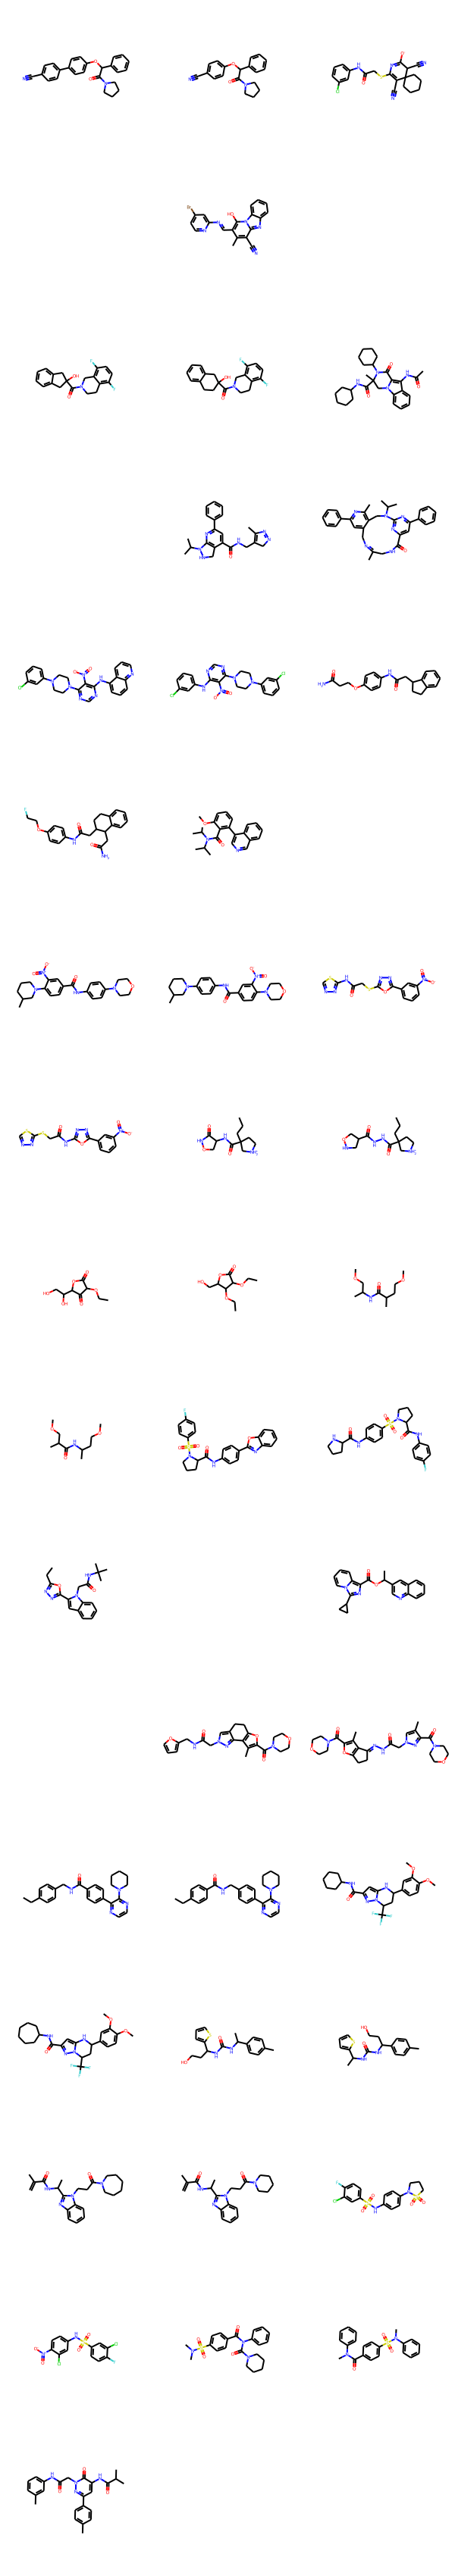

In [10]:
dmols = [Chem.MolFromSmiles(x) for x in dsmiles]
tmols = [Chem.MolFromSmiles(x) for x in tsmiles]

pmols = []
for i in range(len(dmols)):
    pmols += [tmols[i], dmols[i]]
    
Draw.MolsToGridImage(pmols[0:100])

# Similarities of Incorrect Mols

In [11]:
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import DataStructs


tmols_ = [x for i,x in enumerate(tmols) if dsmiles[i] != ""]
dmols_ = [x for i,x in enumerate(dmols) if dsmiles[i] != ""]

fps_tmols = [rdMolDescriptors.GetMorganFingerprintAsBitVect(x, 2) for x in tmols_]
fps_dmols = [rdMolDescriptors.GetMorganFingerprintAsBitVect(x, 2) for x in dmols_]
sim = [DataStructs.TanimotoSimilarity(fps_tmols[i], fps_dmols[i]) for i in range(len(fps_tmols))]

In [12]:
print("mean: %1.2f"%np.mean(sim))
print("std: %1.2f"%np.std(sim))
print("max: %1.2f"%np.max(sim))
print("min: %1.2f"%np.min(sim))

mean: 0.74
std: 0.18
max: 1.00
min: 0.24


(array([ 7., 17., 14., 53., 40., 94., 81., 72., 75., 95.]),
 array([0.23809524, 0.31428571, 0.39047619, 0.46666667, 0.54285714,
        0.61904762, 0.6952381 , 0.77142857, 0.84761905, 0.92380952,
        1.        ]),
 <BarContainer object of 10 artists>)

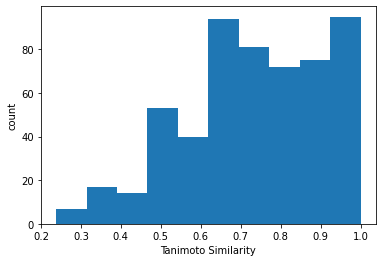

In [13]:
from matplotlib import pyplot
pyplot.xlabel("Tanimoto Similarity")
pyplot.ylabel("count")
pyplot.hist(sim, 10)

# Accuracy-MolWeight

In [14]:
from rdkit.Chem import Descriptors

true_mols = [Chem.MolFromSmiles(x) for x in true_smiles]
mw = [Descriptors.ExactMolWt(x) for x in true_mols]

print(min(mw), max(mw))

154.06626854809 499.1863630040899


In [15]:
smiles_match = [re_can_smiles[i] == true_smiles[i] for i in range(len(true_smiles))]
mw_ = [int(np.ceil(m/50))*50 for m in mw]
x = [mw_, smiles_match]
x = list(map(list, zip(*x)))
x = sorted(x)
mw_, smiles_match = list(map(list,zip(*x)))
mw_count = [mw_.count(i*50) for i in range(4,11)]

num =0
accuracy = []
for c in mw_count:
    accuracy.append(sum(smiles_match[num:num+c])/c)
    num += c
    
accuracy

[0.8105263157894737,
 0.8717277486910995,
 0.9031620553359684,
 0.9033063006862133,
 0.873015873015873,
 0.7768595041322314,
 0.7682926829268293]

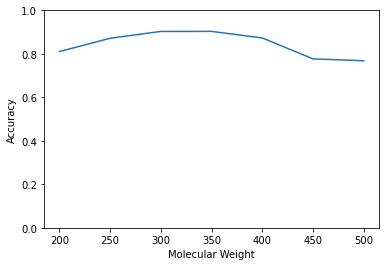

In [16]:
pyplot.xlabel("Molecular Weight")
pyplot.ylabel("Accuracy")
pyplot.ylim([0,1])
pyplot.plot([i*50 for i in range(4,11)], accuracy)

(array([ 109.,  399., 1028., 1631., 1201.,  466.,  166.]),
 array([154.06626855, 203.36913918, 252.67200982, 301.97488046,
        351.27775109, 400.58062173, 449.88349237, 499.186363  ]),
 <BarContainer object of 7 artists>)

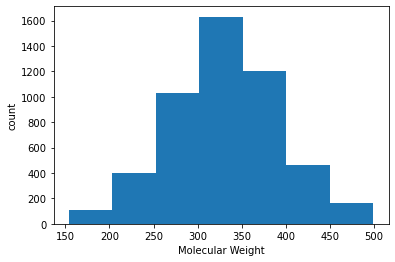

In [17]:
pyplot.ylabel("count")
pyplot.xlabel("Molecular Weight")
pyplot.hist(mw, 7)

# BeamSearch Generation

In [18]:
batch_size=1
true_smiles[1]

#fp_array = smiles_to_fp_array(true_smiles[2])
res, res_score, attention_weights = BeamSearch(transformer, fp_array[:1], target_vocab_size-2, 10, 80)

print(fp_array)

[[2049   34   42 ...    0    0    0]
 [2049  143  192 ...    0    0    0]
 [2049    2   35 ...    0    0    0]
 ...
 [2049    2   39 ...    0    0    0]
 [2049    2   81 ...    0    0    0]
 [2049   35   75 ...    0    0    0]]


In [19]:
def sort_smiles(res, res_score, end_token):
    score = list(tf.concat(res_score, 0).numpy())
    smiles = [array_to_smiles(x, end_token) for x in res]
    smiles = [e for row in smiles for e in row]
    
    x = [score, smiles]
    x = list(map(list, zip(*x)))
    x = sorted(x, reverse=True)
    score, smiles = list(map(list,zip(*x)))
    
    return smiles

[14:38:26] SMILES Parse Error: syntax error while parsing: CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c(2c1
[14:38:26] SMILES Parse Error: Failed parsing SMILES 'CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c(2c1' for input: 'CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c(2c1'
[14:38:26] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19
[14:38:26] SMILES Parse Error: extra open parentheses for input: 'CC(C)(C'


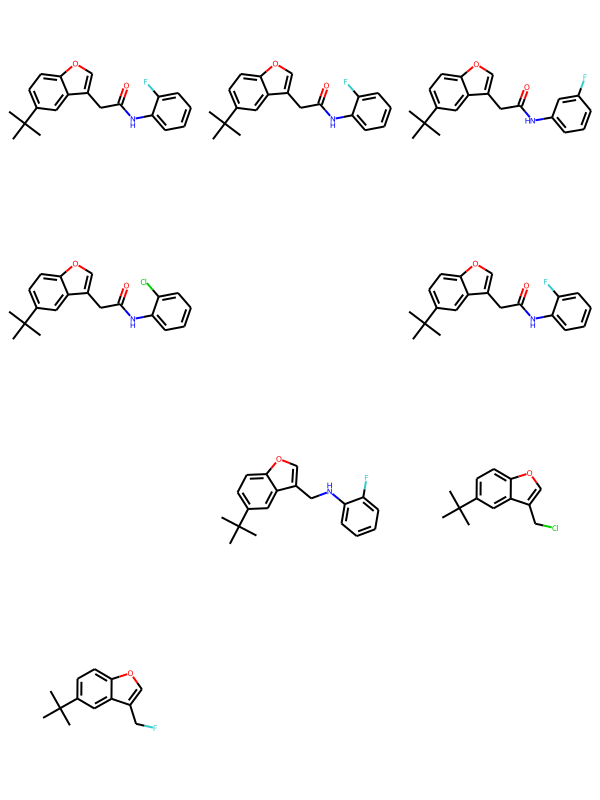

In [20]:
re_smiles = sort_smiles(res, res_score, target_vocab_size-1)
re_mols = [Chem.MolFromSmiles(x) for x in re_smiles]
dmols = [Chem.MolFromSmiles(true_smiles[0])]
dmols.extend(re_mols)

Draw.MolsToGridImage(dmols)